<a href="https://colab.research.google.com/github/marianatmatos/data_science/blob/main/notebooks/Time_Series_with_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series forecasting with Prophet**
---

[![LinkedIn](https://img.shields.io/badge/linkedIn-MarianaMatos-blue.svg)](https://www.linkedin.com/in/mariana-matos-3ba384175/)
[![GitHub](https://img.shields.io/badge/GitHub-marianatmatos-green.svg)](https://github.com/marianatmatos)

<p align="center">
  <img  height="500" src="https://image.freepik.com/vetores-gratis/adote-um-conceito-de-animal-de-estimacao_23-2148532957.jpg" >
</p>

<p align="center"><img src="https://image.freepik.com/vetores-gratis/adote-um-conceito-de-animal-de-estimacao_23-2148532957.jpg" height="500px"></p>

## **O Problema enfrentado em um Abrigo de Animais**

Uma realidade difícil de ignorar é a quantidade de animais sem nenhuma proteção ou cuidado.

Independente de ser no Brasil ou qualquer outro lugar, essas pobres criaturas estão em número alarmantes e, por falta de políticas públicas muitas vezes, acabam mortos, em estados precários ou sendo sacrificados para que haja controle.

Muito por causa disso, há campanhas como as de **não compre animais, adote-os**, para tentar diminuir a reprodução para venda de animais "de raça", enquanto muitos outros padecem sem nunca terem tido chance de um lar para ser cuidado e amado.

O Centro de Animais de Austin, no Texas (Estados Unidos) abriga cerca de 16 mil animais anualmente, independente da raça, idade ou estado de saúde. Como meta, o centro objetiva destinar animais para algum lar seja por meio de adoção, assistência social ou grupos de resgate. Infelizmente, por ser um número muito alto,sacrificar alguns desses animais ainda é uma realidade.

Como meta, o Centro tenta chegar a uma taxa acima dos 90% de saída desses animais com vida.


## Aquisição dos Dados

Os dados foram disponibilizados pelo [Austin Animal Center](http://www.austintexas.gov/content/austin-animal-center) e podem ser baixados diretamente no [City of Austin Open Data Portal](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238).

O *dataset* usado neste *notebook* tem atualização constante e foi atualizado em 26 de fevereiro de 2021 e contém **124K linhas** e **12 colunas**.

In [1]:
# Import libraries 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# configurar a visualização
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Import data to dataframe
df = pd.read_csv('https://github.com/carlosfab/escola-data-science/blob/master/datasets/shelter_animal_outcomes.csv?raw=true')

# Convert DateTime column to datetime format
df.DateTime = pd.to_datetime(df.DateTime)

# See fisrt five entries
df.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,2019-05-08 18:20:00,05/08/2019 06:20:00 PM,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,2018-07-18 16:02:00,07/18/2018 04:02:00 PM,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A720371,Moose,2016-02-13 17:59:00,02/13/2016 05:59:00 PM,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
3,A674754,NaN,2014-03-18 11:47:00,03/18/2014 11:47:00 AM,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby
4,A689724,*Donatello,2014-10-18 18:52:00,10/18/2014 06:52:00 PM,08/01/2014,Adoption,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black


## **EDA**
o date time foi transformado de string para DateTime 
lemrar de comentar: o datetime já está no padrão, caso não estivesse ` df.DateTime = pd.to_datetime(df.DateTime, format=%Y-%m-%d)`

In [3]:
# Statistical summary
df.describe()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
count,117416,80599,117416,117416,117416,117408,53247,117416,117413,117369,117416,117416
unique,104978,18867,96710,96710,6806,9,22,5,5,50,2568,585
top,A721033,Max,2016-04-18 00:00:00,04/18/2016 12:00:00 AM,09/01/2015,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,33,525,39,39,117,51722,29119,66777,41234,21150,30746,12337
first,NaN,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2020-04-30 18:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Summary of variable types and NaN values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117416 entries, 0 to 117415
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Animal ID         117416 non-null  object        
 1   Name              80599 non-null   object        
 2   DateTime          117416 non-null  datetime64[ns]
 3   MonthYear         117416 non-null  object        
 4   Date of Birth     117416 non-null  object        
 5   Outcome Type      117408 non-null  object        
 6   Outcome Subtype   53247 non-null   object        
 7   Animal Type       117416 non-null  object        
 8   Sex upon Outcome  117413 non-null  object        
 9   Age upon Outcome  117369 non-null  object        
 10  Breed             117416 non-null  object        
 11  Color             117416 non-null  object        
dtypes: datetime64[ns](1), object(11)
memory usage: 10.7+ MB


In [5]:
# Count NaN values
df.isnull().sum()

Animal ID               0
Name                36817
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type            8
Outcome Subtype     64169
Animal Type             0
Sex upon Outcome        3
Age upon Outcome       47
Breed                   0
Color                   0
dtype: int64

In [6]:
# See Outcome types
df['Outcome Type'].value_counts()

Adoption           51722
Transfer           34892
Return to Owner    20636
Euthanasia          7890
Died                1075
Rto-Adopt            611
Disposal             495
Missing               67
Relocate              20
Name: Outcome Type, dtype: int64

In [7]:
''' 
Para que possamos trabalhar com series temporais usando o prophet precisamos de um dataframe com duas colunas apenas,
a coluna x(datetime padronizado) e a coluna y(a quantidade de registros do evento)
para isso, foi selecionado da coluna 'Outcome Type' apenas o valor 'Adoption' 
e depois foi criado uma nova coluna 'outcomeCount' a qual foi atribuido 1 à todos os valores. 
E para seguir o padrão proposto pelo prophet atribuimos a culuna 'DateTime' ao index.
'''

# View only 'Adoption' and 'Return to Owner'
adoptions_df = df[(df['Outcome Type'] == 'Adoption')]
adoptions_df['outcomeCount'] = 1

adoptions_df = adoptions_df[['DateTime', 'outcomeCount']]
adoptions_df = adoptions_df.set_index('DateTime').sort_index()
adoptions_df.head()

,outcomeCount
DateTime,
2013-10-01 09:31:00,1
2013-10-01 11:42:00,1
2013-10-01 11:53:00,1
2013-10-01 11:53:00,1
2013-10-01 15:47:00,1


In [9]:
# See min Date and max Date
adoptions_df.index.min(), adoptions_df.index.max()

(Timestamp('2013-10-01 09:31:00'), Timestamp('2020-04-30 14:41:00'))

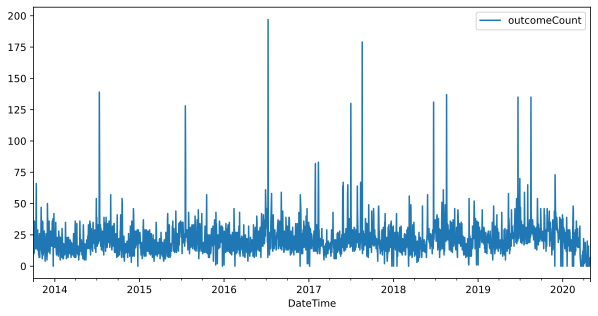

In [10]:
'''
Aqui será usado o método `resample() ` do Pandas para conversão de frequencia em séries temporais, 
neste caso usamos o resample para somar os valores de cada dia.
'''
# Plot Daily graph
fig, ax = plt.subplots(figsize=(10,5))
adoptions_df.resample('D').sum().plot(ax=ax)
plt.show()

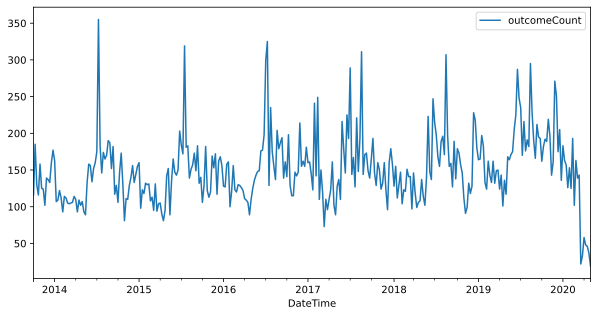

In [11]:
# Plot weekly graph
fig, ax = plt.subplots(figsize=(10,5))
adoptions_df.resample('W').sum().plot(ax=ax)
plt.show()